# Puntaje Bancario: Aprobación de Crédito Mediante Redes Neuronales

En esta ocasión se busca desarrollar un protocolo de pruebas que permita encontrar la mejor arquitectura de red neuronal completamente conectada. En esta ocasión debe utilizar la librería SciKit-Learn (sklearn.neural_network) para diseñar cada red. Además, veremos algunos conceptos de _feature engineering_ para analizar los datos a nuestra disposición.

Debe completar las celdas vacías y seguir las instrucciones anotadas en el cuaderno.

La fecha límite de entrega es el día **18 de octubre** y se realizará a través de Bloque Neón.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

Se tienen dos archivos:

`application_record.csv`: posee información general (puede observar los nombres de las columnas a continuación) sobre cada usuario, definido a partir de una ID única.

- ID: número de cliente
- CODE_GENDER: género
- FLAG_OWN_CAR:	posee un automóvil
- FLAG_OWN_REALTY: posee un inmueble
- CNT_CHILDREN:	cantidad de hijos
- AMT_INCOME_TOTAL:	ingresos anuales
- NAME_INCOME_TYPE: categoría de ingresos
- NAME_EDUCATION_TYPE: nivel educativo
- NAME_FAMILY_STATUS estado civil
- NAME_HOUSING_TYPE: forma de vivienda (e.g. renta, apartamento propio, ...)
- DAYS_BIRTH: fecha de nacimiento, en días hacia atrás desde la actualidad, -1 significa ayer

- DAYS_EMPLOYED: tiempo de empleo, en días hacia atrás desde la actualidad, -1 significa ayer. Si es positivo, el usuario se encuentra desempleado.
- FLAG_MOBIL: teléfono móvil
- FLAG_WORK_PHONE: teléfono de trabajo
- FLAG_PHONE: teléfono
- FLAG_EMAIL: email
- OCCUPATION_TYPE: ocupación
- CNT_FAM_MEMBERS: tamaño de familia


`credit_record.csv`:

- ID: número de cliente
- MONTHS_BALANCE: mes de registro
- ESTADO:
    - 0: 1-29 días atrasados
    - 1: 30-59 días atrasados
    - 2: 60-89 días atrasados
    - 3: 90-119 días atrasados
    - 4: 120-149 días atrasados
    - 5: Atrasados o incobrables, cancelaciones durante más de 150 días
    - C: cancelado ese mes X: sin préstamo durante el mes

In [ ]:
data = pd.read_csv("creditCardScore/application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("creditCardScore/credit_record.csv", encoding = 'utf-8')

In [ ]:
plt.rcParams['figure.facecolor'] = 'white'

In [ ]:
data.tail()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0
438556,6842885,F,N,Y,0,121500.0,Working,Secondary / secondary special,Married,House / apartment,-18858,-1201,1,0,1,0,Sales staff,2.0


In [ ]:
record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


## Preparación de los Datos

### Etiquetas

Inicialmente, se concatenan ambas tablas mediante el tiempo de registro máximo (`MONTHS_BALANCE`) y la ID del cliente.

In [ ]:
# find all users' account open month.
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(data,begin_month,how="left",on="ID") #merge to record data

Los usuarios con mora durante más de 60 días se etiquerarán como `1`, de lo contrario, serán `0`.

In [ ]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']='Yes' 
record['dep_value'][record['STATUS'] =='3']='Yes' 
record['dep_value'][record['STATUS'] =='4']='Yes' 
record['dep_value'][record['STATUS'] =='5']='Yes' 

In [ ]:
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' 
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' 
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='inner',on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes','target']=1
new_data.loc[new_data['target']=='No','target']=0

In [ ]:
print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)

No     45318
Yes      667
Name: dep_value, dtype: int64


No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

Proporción de clases.

### Descriptores

+ Renombramiento de las Columnas

In [ ]:
new_data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        },inplace=True)

In [ ]:
new_data.dropna()
new_data = new_data.mask(new_data == 'NULL').dropna() # Retiramos los valores NaN

In [ ]:
ivtable=pd.DataFrame(new_data.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['FLAG_MOBIL','begin_month','dep_value','target','ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

### Funciones Auxiliares

A continuación se crean algunas funciones que serán utilizadas más adelante.

Función `calc_iv` para obtener las variables IV (information value) y WoE (weight of evidence). Estas variables, de forma general, nos permiten conocer la importancia de cada feature disponible.

Puede encontrar más información en:
- https://www.kaggle.com/puremath86/iv-woe-starter-for-python
- https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html

In [ ]:
# Cálculo de IV
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('El IV de esta variable es:',iv)
    print(df[feature].value_counts())
    return iv, data

In [ ]:
# Codificación One-Hot
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

In [ ]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [ ]:
# Matriz de Confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta')
    plt.xlabel('Predicción')

### Descriptores Binarios

Se utilizará la función desarrollada anteriormente para realizar un análisis de cada uno de los descriptores binarios y **su influencia dentro de la predicción de cada clase**.

#### Género

In [ ]:
new_data['Gender'] = new_data['Gender'].replace(['F','M'],[0,1])
print(new_data['Gender'].value_counts())
iv, data = calc_iv(new_data,'Gender','target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv
data.head()

0    15630
1     9504
Name: Gender, dtype: int64
El IV de esta variable es: 0.02520350452745081
0    15630
1     9504
Name: Gender, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,15630,15400,230,0.621867,0.014715,0.623179,0.545024,0.134005,0.010473
1,Gender,1,9504,9312,192,0.378133,0.020202,0.376821,0.454976,-0.188475,0.014730


#### Posesión de un Automóvil

In [ ]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
print(new_data['Car'].value_counts())
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

0    14618
1    10516
Name: Car, dtype: int64
El IV de esta variable es: 4.54248124999671e-06
0    14618
1    10516
Name: Car, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,14618,14373,245,0.581603,0.016760,0.58162,0.580569,0.00181,0.000002
1,Car,1,10516,10339,177,0.418397,0.016831,0.41838,0.419431,-0.00251,0.000003


#### Posesión de un Inmueble

In [ ]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
print(new_data['Reality'].value_counts())
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

1    16461
0     8673
Name: Reality, dtype: int64
El IV de esta variable es: 0.02744070350168343
1    16461
0     8673
Name: Reality, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,8673,8494,179,0.34507,0.020639,0.34372,0.424171,-0.210309,0.016920
1,Reality,1,16461,16218,243,0.65493,0.014762,0.65628,0.575829,0.130777,0.010521


#### Posesión de un Teléfono

In [ ]:
new_data['phone']=new_data['phone'].astype(str)
print(new_data['phone'].value_counts(normalize=True,sort=False))
new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

0    0.707209
1    0.292791
Name: phone, dtype: float64
El IV de esta variable es: 0.0005480495762639297
0    17775
1     7359
Name: phone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,17775,17481,294,0.707209,0.016540,0.707389,0.696682,0.015251,0.000163
1,phone,1,7359,7231,128,0.292791,0.017394,0.292611,0.303318,-0.035937,0.000385


#### Posesión de Correo Electrónico (Email)

In [ ]:
print(new_data['email'].value_counts(normalize=True,sort=False))
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

0    0.89934
1    0.10066
Name: email, dtype: float64
El IV de esta variable es: 1.7343581493999816e-05
0    22604
1     2530
Name: email, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,22604,22225,379,0.89934,0.016767,0.899361,0.898104,0.001398,0.000002
1,email,1,2530,2487,43,0.10066,0.016996,0.100639,0.101896,-0.012407,0.000016


#### Posesión de Teléfono para Trabajo

In [ ]:
new_data['wkphone']=new_data['wkphone'].astype(str)
iv, data = calc_iv(new_data,'wkphone','target')
new_data.drop(new_data[new_data['wkphone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='wkphone','IV']=iv
data.head()

El IV de esta variable es: 0.002042429795148461
0    18252
1     6882
Name: wkphone, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,wkphone,0,18252,17954,298,0.726188,0.016327,0.72653,0.706161,0.028436,0.000579
1,wkphone,1,6882,6758,124,0.273812,0.018018,0.27347,0.293839,-0.071838,0.001463


### Descriptores Continuos

#### Cantidad de Hijos

In [ ]:
# Separamos aquellos que: no tienen hijos, tienen 1 hijo, tienen 2 o más hijos.

new_data.loc[new_data['ChldNo'] >= 2,'ChldNo']='2More'
print(new_data['ChldNo'].value_counts(sort=False))

0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


In [ ]:
iv, data=calc_iv(new_data,'ChldNo','target')
ivtable.loc[ivtable['variable']=='ChldNo','IV']=iv
data.head()

El IV de esta variable es: 0.0011214542503301935
0        15908
1         6118
2More     3108
Name: ChldNo, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,ChldNo,0,15908,15635,273,0.632928,0.017161,0.632689,0.646919,-0.022243,0.000317
1,ChldNo,1,6118,6021,97,0.243415,0.015855,0.243647,0.229858,0.058259,0.000803
2,ChldNo,2More,3108,3056,52,0.123657,0.016731,0.123665,0.123223,0.003580,0.000002


In [ ]:
new_data = convert_dummy(new_data,'ChldNo') # Adicionamos una Codificación One-Hot

In [ ]:
new_data.head()

,ID,Gender,Car,Reality,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,wkphone,phone,email,occyp,famsize,begin_month,dep_value,target,ChldNo_1,ChldNo_2More
2,5008806,1,1,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0,0,0
3,5008808,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0,0,0
4,5008809,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0,0,0
5,5008810,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0,0,0
6,5008811,0,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-38.0,No,0,0,0


#### Ingresos Anuales

Gráfica de Histograma para observar la distribución.

In [ ]:
new_data['inc'] = new_data['inc'].astype(object)
new_data['inc'] = new_data['inc']/10000 
print(new_data['inc'].value_counts(bins=10,sort=False))

(2.544, 18.18]      14663
(18.18, 33.66]       8464
(33.66, 49.14]       1637
(49.14, 64.62]        175
(64.62, 80.1]         124
(80.1, 95.58]          50
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        6
(142.02, 157.5]         8
Name: inc, dtype: int64


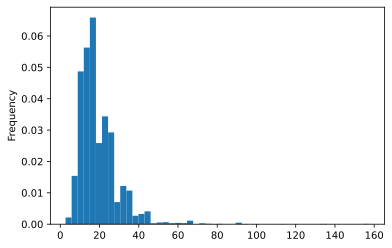

In [ ]:
new_data['inc'].plot(kind='hist',bins=50,density=True)

In [ ]:
new_data = get_category(new_data,'inc', 3, ["low","medium", "high"], qcut = True)
iv, data = calc_iv(new_data,'gp_inc','target')
ivtable.loc[ivtable['variable']=='inc','IV']=iv
data.head()
new_data.keys()

El IV de esta variable es: 0.0024219962221596752
low       8996
high      8244
medium    7894
Name: gp_inc, dtype: int64


Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'inctp', 'edutp', 'famtp',
       'houtp', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone',
       'phone', 'email', 'occyp', 'famsize', 'begin_month', 'dep_value',
       'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc'],
      dtype='object')

In [ ]:
new_data = convert_dummy(new_data,'gp_inc')

#### Edad

In [ ]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))

(19.951999999999998, 24.7]    0.025066
(24.7, 29.4]                  0.134280
(29.4, 34.1]                  0.169770
(34.1, 38.8]                  0.140805
(38.8, 43.5]                  0.173072
(43.5, 48.2]                  0.141880
(48.2, 52.9]                  0.099069
(52.9, 57.6]                  0.076550
(57.6, 62.3]                  0.032585
(62.3, 67.0]                  0.006923
Name: Age, dtype: float64


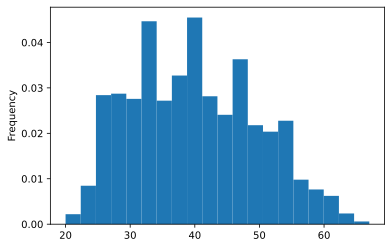

In [ ]:
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [ ]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

El IV de esta variable es: 0.06593513858884348
medium     7916
low        7806
high       4414
lowest     4005
highest     993
Name: gp_Age, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,4414,4323,91,0.175619,0.020616,0.174935,0.215640,-0.209194,0.008515
1,gp_Age,highest,993,989,4,0.039508,0.004028,0.040021,0.009479,1.440361,0.043992
2,gp_Age,low,7806,7686,120,0.310575,0.015373,0.311023,0.284360,0.089625,0.002390
3,gp_Age,lowest,4005,3921,84,0.159346,0.020974,0.158668,0.199052,-0.226754,0.009157
4,gp_Age,medium,7916,7793,123,0.314952,0.015538,0.315353,0.291469,0.078758,0.001881


In [ ]:
new_data = convert_dummy(new_data,'gp_Age')

#### Años de Trabajo

In [ ]:
new_data['worktm']=-(new_data['DAYS_EMPLOYED'])//365
new_data[new_data['worktm']<0] = np.nan # replace by na
new_data['DAYS_EMPLOYED']
new_data['worktm'].fillna(new_data['worktm'].mean(),inplace=True) #replace na by mean

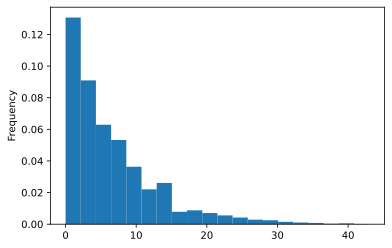

In [ ]:
new_data['worktm'].plot(kind='hist',bins=20,density=True)

In [ ]:
new_data = get_category(new_data,'worktm',5, ["lowest","low","medium","high","highest"])
iv, data=calc_iv(new_data,'gp_worktm','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

El IV de esta variable es: 0.04022152230816303
lowest     18254
low         4987
medium      1378
high         425
highest       90
Name: gp_worktm, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_worktm,high,425,423,2,0.016909,0.004706,0.017117,0.004739,1.284186,0.015895
1,gp_worktm,highest,90,90,0,0.003581,0.000000,0.003642,0.000000,0.000000,0.000000
2,gp_worktm,low,4987,4921,66,0.198416,0.013234,0.199134,0.156398,0.241573,0.010324
3,gp_worktm,lowest,18254,17916,338,0.726267,0.018516,0.724992,0.800948,-0.099635,0.007568
4,gp_worktm,medium,1378,1362,16,0.054826,0.011611,0.055115,0.037915,0.374082,0.006434


In [ ]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'gp_worktm')

#### Tamaño de Familia

In [ ]:
new_data['famsize'].value_counts(sort=False)

2.0     12697
1.0      4263
3.0      5216
4.0      2576
6.0        51
9.0         2
5.0       307
7.0        18
20.0        1
15.0        3
Name: famsize, dtype: int64

In [ ]:
new_data['famsize']=new_data['famsize'].astype(int)
new_data['famsizegp']=new_data['famsize']
new_data['famsizegp']=new_data['famsizegp'].astype(object)
new_data.loc[new_data['famsizegp']>=3,'famsizegp']='3more'
iv, data=calc_iv(new_data,'famsizegp','target')
ivtable.loc[ivtable['variable']=='famsize','IV']=iv
data.head()

El IV de esta variable es: 0.006156138510778323
2        12697
3more     8174
1         4263
Name: famsizegp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famsizegp,1,4263,4179,84,0.169611,0.019704,0.169108,0.199052,-0.163028,0.004882
1,famsizegp,2,12697,12489,208,0.505172,0.016382,0.505382,0.492891,0.025027,0.000313
2,famsizegp,3more,8174,8044,130,0.325217,0.015904,0.325510,0.308057,0.055108,0.000962


In [ ]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'famsizegp')

### Descriptores Categóricos

#### Forma de Ingresos

In [ ]:
print(new_data['inctp'].value_counts(sort=False))
print(new_data['inctp'].value_counts(normalize=True,sort=False))
new_data.loc[new_data['inctp']=='Pensioner','inctp']='State servant'
new_data.loc[new_data['inctp']=='Student','inctp']='State servant'
iv, data=calc_iv(new_data,'inctp','target')
ivtable.loc[ivtable['variable']=='inctp','IV']=iv
data.head()

Student                    10
Working                 15622
State servant            2437
Pensioner                  13
Commercial associate     7052
Name: inctp, dtype: int64
Student                 0.000398
Working                 0.621549
State servant           0.096960
Pensioner               0.000517
Commercial associate    0.280576
Name: inctp, dtype: float64
El IV de esta variable es: 5.159303327851404e-05
Working                 15622
Commercial associate     7052
State servant            2460
Name: inctp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,inctp,Commercial associate,7052,6933,119,0.280576,0.016875,0.280552,0.281991,-0.005115,0.000007
1,inctp,State servant,2460,2418,42,0.097875,0.017073,0.097847,0.099526,-0.017013,0.000029
2,inctp,Working,15622,15361,261,0.621549,0.016707,0.621601,0.618483,0.005028,0.000016


In [ ]:
# Codificación One-Hot
new_data = convert_dummy(new_data,'inctp')

#### Tipo de Ocupación

In [ ]:
new_data.loc[(new_data['occyp']=='Cleaning staff') | (new_data['occyp']=='Cooking staff') | (new_data['occyp']=='Drivers') | (new_data['occyp']=='Laborers') | (new_data['occyp']=='Low-skill Laborers') | (new_data['occyp']=='Security staff') | (new_data['occyp']=='Waiters/barmen staff'),'occyp']='Laborwk'
new_data.loc[(new_data['occyp']=='Accountants') | (new_data['occyp']=='Core staff') | (new_data['occyp']=='HR staff') | (new_data['occyp']=='Medicine staff') | (new_data['occyp']=='Private service staff') | (new_data['occyp']=='Realty agents') | (new_data['occyp']=='Sales staff') | (new_data['occyp']=='Secretaries'),'occyp']='officewk'
new_data.loc[(new_data['occyp']=='Managers') | (new_data['occyp']=='High skill tech staff') | (new_data['occyp']=='IT staff'),'occyp']='hightecwk'
print(new_data['occyp'].value_counts())
iv, data=calc_iv(new_data,'occyp','target')
ivtable.loc[ivtable['variable']=='occyp','IV']=iv
data.head()         

Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64
El IV de esta variable es: 0.004820472062853304
Laborwk      10496
officewk     10183
hightecwk     4455
Name: occyp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occyp,Laborwk,10496,10311,185,0.417602,0.017626,0.417247,0.438389,-0.049428,0.001045
1,occyp,hightecwk,4455,4375,80,0.177250,0.017957,0.177039,0.189573,-0.068404,0.000857
2,occyp,officewk,10183,10026,157,0.405148,0.015418,0.405714,0.372038,0.086652,0.002918


In [ ]:
new_data = convert_dummy(new_data,'occyp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'houtp',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone',
       'email', 'famsize', 'begin_month', 'dep_value', 'target', 'ChldNo_1',
       'ChldNo_2More', 'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high',
       'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest', 'worktm',
       'gp_worktm_high', 'gp_worktm_highest', 'gp_worktm_low',
       'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk'],
      dtype='object')

#### Forma de Vivienda

In [ ]:
iv, data=calc_iv(new_data,'houtp','target')
ivtable.loc[ivtable['variable']=='houtp','IV']=iv
data.head()

El IV de esta variable es: 0.0073275026880227365
House / apartment      22102
With parents            1430
Municipal apartment      812
Rented apartment         439
Office apartment         199
Co-op apartment          152
Name: houtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,houtp,Co-op apartment,152,149,3,0.006048,0.019737,0.006029,0.007109,-0.164705,0.000178
1,houtp,House / apartment,22102,21738,364,0.879367,0.016469,0.879654,0.862559,0.019624,0.000335
2,houtp,Municipal apartment,812,793,19,0.032307,0.023399,0.032090,0.045024,-0.338655,0.004380
3,houtp,Office apartment,199,194,5,0.007918,0.025126,0.007850,0.011848,-0.411619,0.001646
4,houtp,Rented apartment,439,433,6,0.017466,0.013667,0.017522,0.014218,0.208939,0.000690


In [ ]:
new_data = convert_dummy(new_data,'houtp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'edutp', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents'],
      dtype='object')

#### Educación

In [ ]:
new_data.loc[new_data['edutp']=='Academic degree','edutp']='Higher education'
iv, data=calc_iv(new_data,'edutp','target')
ivtable.loc[ivtable['variable']=='edutp','IV']=iv
data.head()

El IV de esta variable es: 0.010361794017679489
Secondary / secondary special    16808
Higher education                  7146
Incomplete higher                  993
Lower secondary                    187
Name: edutp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edutp,Higher education,7146,7018,128,0.284316,0.017912,0.283992,0.303318,-0.065836,0.001272
1,edutp,Incomplete higher,993,972,21,0.039508,0.021148,0.039333,0.049763,-0.235206,0.002453
2,edutp,Lower secondary,187,181,6,0.007440,0.032086,0.007324,0.014218,-0.663301,0.004573
3,edutp,Secondary / secondary special,16808,16541,267,0.668736,0.015885,0.669351,0.632701,0.056310,0.002064


In [ ]:
new_data = convert_dummy(new_data,'edutp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'famtp', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize',
       'begin_month', 'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More',
       'gp_inc_high', 'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest',
       'gp_Age_low', 'gp_Age_lowest', 'worktm', 'gp_worktm_high',
       'gp_worktm_highest', 'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1',
       'famsizegp_3more', 'inctp_Commercial associate', 'inctp_State servant',
       'occyp_hightecwk', 'occyp_officewk', 'houtp_Co-op apartment',
       'houtp_Municipal apartment', 'houtp_Office apartment',
       'houtp_Rented apartment', 'houtp_With parents',
       'edutp_Higher education', 'edutp_Incomplete higher',
       'edutp_Lower secondary'],
      dtype='object')

####  Estado Civil

In [ ]:
new_data['famtp'].value_counts(normalize=True,sort=False)

Single / not married    0.137065
Widow                   0.023076
Married                 0.696626
Separated               0.058367
Civil marriage          0.084865
Name: famtp, dtype: float64

In [ ]:
iv, data=calc_iv(new_data,'famtp','target')
ivtable.loc[ivtable['variable']=='famtp','IV']=iv
data.head()

El IV de esta variable es: 0.043137115423127946
Married                 17509
Single / not married     3445
Civil marriage           2133
Separated                1467
Widow                     580
Name: famtp, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,famtp,Civil marriage,2133,2101,32,0.084865,0.015002,0.085019,0.075829,0.114394,0.001051
1,famtp,Married,17509,17232,277,0.696626,0.015820,0.697313,0.656398,0.060467,0.002474
2,famtp,Separated,1467,1452,15,0.058367,0.010225,0.058757,0.035545,0.502608,0.011666
3,famtp,Single / not married,3445,3362,83,0.137065,0.024093,0.136047,0.196682,-0.368588,0.022349
4,famtp,Widow,580,565,15,0.023076,0.025862,0.022863,0.035545,-0.441263,0.005596


In [ ]:
new_data = convert_dummy(new_data,'famtp')

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

## Utilidad de: IV y WoE

Puede leer el artículo a continuación para comprender un poco más sobre los conceptos de IV y WoE:

https://docs.tibco.com/pub/sfire-dsc/6.5.0/doc/html/TIB_sfire-dsc_user-guide/GUID-07A78308-525A-406F-8221-9281F4E9D7CF.html

La tabla a continuación fue tomada de la referencia indicada:

| IV| Ability to predict | 
|:------|:------:| 
| <0.02 | Bajo poder predictivo | 
|0.02~0.1 |Poder predictivo débil|
|0.1~0.3|Poder predictivo moderado|
|0.3~0.5|Poder predictivo fuerte|
|>0.5|Sospechosamente alto, revisar esta variable| 

In [ ]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='agegp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='worktmgp'
ivtable.loc[ivtable['variable']=='inc','variable']='incgp'
ivtable

,variable,IV
10,agegp,0.0659351
8,famtp,0.0431371
11,worktmgp,0.0402215
3,Reality,0.0274407
1,Gender,0.0252035
7,edutp,0.0103618
9,houtp,0.0073275
17,famsize,0.00615614
16,occyp,0.00482047
5,incgp,0.002422


De acuerdo a lo mencionado en la referencia, las variables con las que se cuenta tienen un bajo poder predictivo; sin embargo, un buen conjunto de estas se encuentran con un IV cercano, por lo que sería bueno tomar aquellas variables cuyo IV se encuentre en un orden de magnitud superior o igual a $10^{-3}$ pues es donde se presenta la diferencia más grande de IV para las variables como se observa en la lista presentada anteriormente.

# Predicción de Buen/Mal Cliente Mediante Redes Neuronales

+ Split Dataset

In [ ]:
new_data.columns

Index(['ID', 'Gender', 'Car', 'Reality', 'inc', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'wkphone', 'phone', 'email', 'famsize', 'begin_month',
       'dep_value', 'target', 'ChldNo_1', 'ChldNo_2More', 'gp_inc_high',
       'gp_inc_medium', 'Age', 'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
       'gp_Age_lowest', 'worktm', 'gp_worktm_high', 'gp_worktm_highest',
       'gp_worktm_low', 'gp_worktm_medium', 'famsizegp_1', 'famsizegp_3more',
       'inctp_Commercial associate', 'inctp_State servant', 'occyp_hightecwk',
       'occyp_officewk', 'houtp_Co-op apartment', 'houtp_Municipal apartment',
       'houtp_Office apartment', 'houtp_Rented apartment',
       'houtp_With parents', 'edutp_Higher education',
       'edutp_Incomplete higher', 'edutp_Lower secondary',
       'famtp_Civil marriage', 'famtp_Separated', 'famtp_Single / not married',
       'famtp_Widow'],
      dtype='object')

Se tomarán únicamente aquellas columnas preprocesadas y con un $IV>0.001$

In [ ]:
Y = new_data['target']
X = new_data[['Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
              'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
              'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
              'occyp_officewk','famsizegp_1', 'famsizegp_3more',
              'houtp_Co-op apartment', 'houtp_Municipal apartment',
              'houtp_Office apartment', 'houtp_Rented apartment',
              'houtp_With parents','edutp_Higher education',
              'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
              'famtp_Separated','famtp_Single / not married','famtp_Widow']]

### SMOTE

Concepto: Synthetic Minority Over-Sampling Technique(`SMOTE`) utilizado para lidiar con datos desbalanceados. Puede encontrar más información en:

- http://glemaitre.github.io/imbalanced-learn/generated/imblearn.over_sampling.SMOTE.html
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
Y = Y.astype('int')
sm = SMOTE()
X_balance,Y_balance = sm.fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

Separación de datos en conjuntos: entrenamiento y prueba.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

# \*Seleccione esta celda y luego la opción `Run All Above`\*

# PARTE 1

## Separación de Conjunto de Features

Teniendo en cuenta los resultados de IV obtenidos anteriormente, comprobaremos la capacidad predictiva de tres conjuntos de datos basados en la tabla anterior. Primero removeremos los últimos cuatro ('phone', 'inctp', 'email', 'Car'), y luego realizaremos la siguiente división:

- A. Primera mitad: 'agegp', 'famtp', 'worktmgp', 'Reality', 'Gender', 'edutp'
- B. Segunda mitad: 'houtp', 'famsize', 'occyp', 'incgp', 'wkphone', 'ChldNo'
- C. Todos los descriptores.

De acuerdo a estos nombres, utilice la siguiente lista para identificar aquellos solicitados en cada caso:
```
    'Gender','Reality','ChldNo_1', 'ChldNo_2More', 'gp_inc_medium',  'gp_inc_high','wkphone',
    'gp_Age_high', 'gp_Age_highest', 'gp_Age_low',
    'gp_Age_lowest','gp_worktm_high', 'gp_worktm_highest',
    'gp_worktm_low', 'gp_worktm_medium','occyp_hightecwk', 
    'occyp_officewk','famsizegp_1', 'famsizegp_3more',
    'houtp_Co-op apartment', 'houtp_Municipal apartment',
    'houtp_Office apartment', 'houtp_Rented apartment',
    'houtp_With parents','edutp_Higher education',
    'edutp_Incomplete higher', 'edutp_Lower secondary','famtp_Civil marriage',
    'famtp_Separated','famtp_Single / not married','famtp_Widow'
```
### A. Top 6

In [ ]:
#Se seleccionan las columnas con las que se va a ejecutar el modelo para el primer caso
X_train_subA = X_train[['Reality','gp_Age_high','gp_Age_highest','gp_Age_low',
    'gp_Age_lowest','famtp_Civil marriage',
    'famtp_Separated','famtp_Single / not married','famtp_Widow', 'gp_worktm_high', 'gp_worktm_highest',
    'gp_worktm_low', 'gp_worktm_medium', 'Gender','edutp_Higher education',
    'edutp_Incomplete higher', 'edutp_Lower secondary']]

X_test_subA = X_test[['Reality','gp_Age_high','gp_Age_highest','gp_Age_low',
    'gp_Age_lowest','famtp_Civil marriage',
    'famtp_Separated','famtp_Single / not married','famtp_Widow', 'gp_worktm_high', 'gp_worktm_highest',
    'gp_worktm_low', 'gp_worktm_medium', 'Gender','edutp_Higher education',
    'edutp_Incomplete higher', 'edutp_Lower secondary']]

X_train_subA.head()

,Reality,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,Gender,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary
32515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14471,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16400,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
39904,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### B. Últimos 6

In [ ]:
#seleccion de columnas a usar para ejecutar el caso 2
X_train_subB = X_train[['houtp_Co-op apartment', 'houtp_Municipal apartment',
    'houtp_Office apartment', 'houtp_Rented apartment',
    'houtp_With parents','famsizegp_1', 'famsizegp_3more','occyp_hightecwk', 
    'occyp_officewk', 'gp_inc_medium',  'gp_inc_high','wkphone','ChldNo_1', 'ChldNo_2More']]

X_test_subB = X_test[['houtp_Co-op apartment', 'houtp_Municipal apartment',
    'houtp_Office apartment', 'houtp_Rented apartment',
    'houtp_With parents','famsizegp_1', 'famsizegp_3more','occyp_hightecwk', 
    'occyp_officewk', 'gp_inc_medium',  'gp_inc_high','wkphone','ChldNo_1', 'ChldNo_2More']]

X_train_subB.head()

,houtp_Co-op apartment,houtp_Municipal apartment,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,famsizegp_1,famsizegp_3more,occyp_hightecwk,occyp_officewk,gp_inc_medium,gp_inc_high,wkphone,ChldNo_1,ChldNo_2More
32515,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
14471,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
16400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
29956,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
39904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Caso C

Acá simplemente tomaremos, no es necesario crear nuevas variables:
```
X_train_subC = X_train
X_test_subC = X_test
```

# PARTE 2

Implementación de pruebas en los conjuntos de descriptores. A continuación debe implementar, inicialmente tres modelos de regresión logística, y posteriormente tres redes neuronales (2 capas escondidas, 20 neuronas en cada una). Observe los resultados y analice lo sucedido. Concluya sobre qué modelo es deseable teniendo en cuenta la factibilidad de implementación práctica y la matriz de confusión correspondiente.

## Regresión Logística

Inicialmente se probará un modelo de regresión logística para tener una referencia (también se conoce como _baseline_) y comprobar que un modelo de red neuronal permite obtener mejores resultados.

$$\log ({p \over {1 - p}}) = {\beta _0} + {\beta _1}{x_1} +  \cdot  \cdot  \cdot  + {\beta _q}{x_q}$$

### Caso A

Precisión 0.59536
      0     1
0  3878  3536
1  2464  4950
Sensitividad: 0.6677 Especificidad: 0.5231

[[3878 3536]
 [2464 4950]]


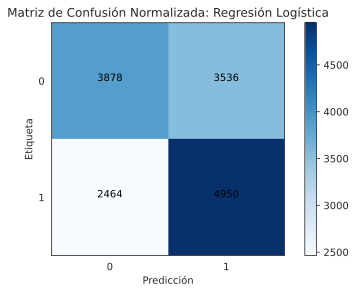

In [ ]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subA,y_train) # Ajuste el modelo con los datos del conjunto A #
y_predict = model.predict(X_test_subA) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))
cmA = confusion_matrix(y_test,y_predict)
print(f'''Sensitividad: {round(cmA[1,1]/(float(cmA[1,1]+cmA[1,0])), 4)} Especificidad: {round(cmA[0,0]/(float(cmA[0,0]+cmA[0,1])), 4)}\n''')

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')

## Caso B

Precisión 0.53143
      0     1
0  3883  3531
1  3417  3997
Sensitividad: 0.5391 Especificidad: 0.5237

[[3883 3531]
 [3417 3997]]


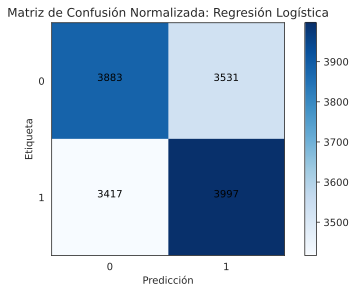

In [ ]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train_subB,y_train) # Ajuste el modelo con los datos del conjunto B #
y_predict = model.predict(X_test_subB) # Realice la predicción de etiquetas con los datos de prueba del conjunto B #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))
cmB = confusion_matrix(y_test,y_predict)
print(f'''Sensitividad: {round(cmB[1,1]/(float(cmB[1,1]+cmB[1,0])), 4)} Especificidad: {round(cmB[0,0]/(float(cmB[0,0]+cmB[0,1])), 4)}\n''')

#sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')


## Caso C

Precisión 0.60548
      0     1
0  3956  3458
1  2392  5022
Sensitividad: 0.6774 Especificidad: 0.5336

[[3956 3458]
 [2392 5022]]


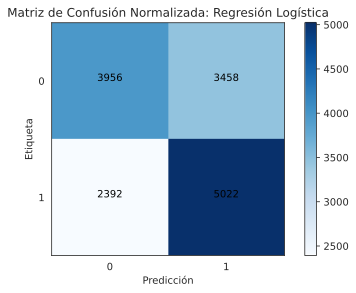

In [ ]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train,y_train) # Ajuste el modelo con los datos del conjunto C #
y_predict = model.predict(X_test) # Realice la predicción de etiquetas con los datos de prueba del conjunto C #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))
cmC = confusion_matrix(y_test,y_predict)
print(f'''Sensitividad: {round(cmC[1,1]/(float(cmC[1,1]+cmC[1,0])), 4)} Especificidad: {round(cmC[0,0]/(float(cmC[0,0]+cmC[0,1])), 4)}\n''')

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, 
                      title='Matriz de Confusión Normalizada: Regresión Logística')


# **Conclusiones regresión logística**
Si bien el modelo al hacer uso de todas las variables que para este caso tienen mayor importancia puede subir un poco su precisión, los resultados no son muy buenos pues esta es de únicamente de $0.6$. Además, al observar los índices de sensitividad y especificidad también es claro ver que el modelo en realidad no hace una buena distinción entre verdaderos positivos y negativos. Por lo tanto, para mí no resulta ser muy confiable comparado con los resultados que se llegaron a obtener por ejemplo en la tarea 2.

## Red Neuronal, Perceptrón Multicapa

Ahora utilice la función `MLPClassifier` de la librería SciKit-Learn para desarrollar una red neuronal que permita mejorar el rendimiento del clasificador _baseline_ desarrollado.

### Caso A

Precisión 0.81616
      0     1
0  6273  1141
1  1585  5829
Sensitividad: 0.7862 Especificidad: 0.8461

[[6273 1141]
 [1585 5829]]


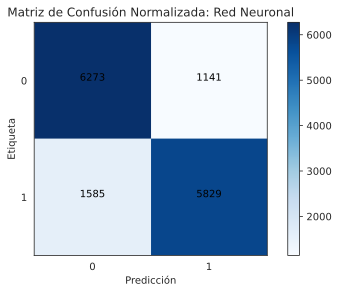

In [ ]:
from sklearn.neural_network import MLPClassifier

#recordar que hidden_layer_sizes recibe una tupla en donde se denotan el numero de neuronas por capas escondidas
#se mantiene el mismo solver de la regresion logistica para resolver el mismo problema de optimizacion
model = MLPClassifier(hidden_layer_sizes = (20,20), activation = 'relu', solver = 'lbfgs') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train_subA,y_train) # Ajuste el modelo con los datos del conjunto A #
y_predict = model.predict(X_test_subA) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))
cmA = confusion_matrix(y_test,y_predict)
print(f'''Sensitividad: {round(cmA[1,1]/(float(cmA[1,1]+cmA[1,0])), 4)} Especificidad: {round(cmA[0,0]/(float(cmA[0,0]+cmA[0,1])), 4)}\n''')

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Caso B

Precisión 0.78129
      0     1
0  6142  1272
1  1971  5443
Sensitividad: 0.7342 Especificidad: 0.8284

[[6142 1272]
 [1971 5443]]


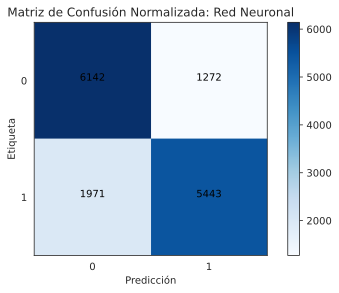

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes = (20,20), activation = 'relu', solver = 'lbfgs') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train_subB,y_train) # Ajuste el modelo con los datos del conjunto B #
y_predict = model.predict(X_test_subB) # Realice la predicción de etiquetas con los datos de prueba del conjunto B #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))
cmB = confusion_matrix(y_test,y_predict)
print(f'''Sensitividad: {round(cmB[1,1]/(float(cmB[1,1]+cmB[1,0])), 4)} Especificidad: {round(cmB[0,0]/(float(cmB[0,0]+cmB[0,1])), 4)}\n''')
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Caso C

Precisión 0.93917
      0     1
0  6823   591
1   311  7103
Sensitividad: 0.9581 Especificidad: 0.9203

[[6823  591]
 [ 311 7103]]


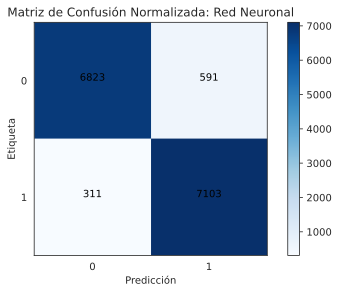

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes = (20,20), activation = 'relu', solver = 'lbfgs') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train,y_train) # Ajuste el modelo con los datos del conjunto C #
y_predict = model.predict(X_test) # Realice la predicción de etiquetas con los datos de prueba del conjunto Cmm #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))
cmC = confusion_matrix(y_test,y_predict)
print(f'''Sensitividad: {round(cmC[1,1]/(float(cmC[1,1]+cmC[1,0])), 4)} Especificidad: {round(cmC[0,0]/(float(cmC[0,0]+cmC[0,1])), 4)}\n''')
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

### Conclusiones Parte 2

Los resultados haciendo uso de redes neuronales mejoran de manera considerable pues la precisión más baja que se obtuvo fue de 0.78. Además, si analizamos la sensitividad especificidad estos toman valores muy buenos, incluso mucho mejores de los que se tenían para la tarea 2. Esto significa que con esta red que contiene un número de 20 neuronas en dos capas ocultas es más fácil hacer una buena predicción de un buen o mal cliente.


# PARTE 3

Los resultados obtenidos para las redes neuronales anteriores únicamente corresponden a una arquitectura. Un proceso necesario e importante en casos de estudio como este es la búsqueda de hiperparámetros, en este caso, el número de neuronas más adecuado (al menos dentro de cierto rango, este proceso también se conoce como [GridSearch](https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e)).

**Divida el conjunto de datos de prueba en dos mitades: datos de validación y datos de prueba. Utilice los datos de validación para realizar una evaluación preliminar de cada modelo.** Utilice `train_test_split` para esta parte.

Utilice todos los descriptores para esta prueba y realice las siguientes búsquedas:

- Caso A: 1 capa escondida $\times$ {5, 10, 20, 50, 100} neuronas.
- Caso B: 2 capas escondidas $\times$ {5, 10, 20, 50, 100} neuronas.
- Caso C: 3 capas escondidas $\times$ {5, 10, 20, 50, 100} neuronas.

Utilice `matplotlib.pyplot` para graficar la precisión en los datos de validación, seleccione el mejor modelo, y obtenga una evaluación final para esta selección utilizando los datos de prueba.

### Caso A

Text(0, 0.5, 'Precision')

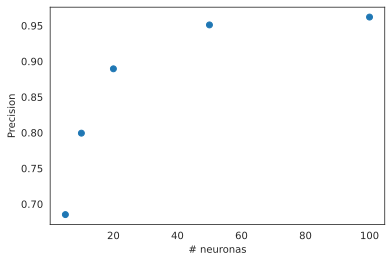

In [ ]:
#aqui se analiza el primer caso en donde se varía el número de neuronas para una sola capa escondida
#se vuelven a dividir los datos que se tenían en entrenamiento en donde la mitad  van a ser usados para entrenar y la otra mitad para validar
X_train1, X_validation, y_train1, y_validation = train_test_split(X_train,y_train, test_size=0.5)
n_list = [5,10,20,50,100]  #numero de neuronas a usar en la capa
precision_a = []  #lista que va a guardar los valores de precision para cada modelo a evaluar
#for para variar el numero de neuronas
for i in n_list:
  model = MLPClassifier(hidden_layer_sizes = (i), activation = 'relu', solver = 'lbfgs')  #se describe el modelo el cual tiene una capa escondida y varia el numero de neuronas
  model.fit(X_train1,y_train1)
  y_predict1 = model.predict(X_validation)
  precision_a.append(round(accuracy_score(y_validation, y_predict1),5))
#grafica de precision vs el numero de neuronas
plt.scatter(n_list, precision_a)
plt.xlabel('# neuronas')
plt.ylabel('Precision')

### Caso B

Text(0, 0.5, 'Precision')

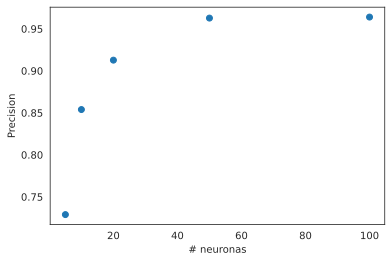

In [ ]:
#aqui se analiza el segundo caso en donde se varía el número de neuronas para dos capas escondidas
n_list = [5,10,20,50,100] #numero de neuronas a incluir en cada capa
precision_b = [] #lista con las precisiones de los distintos modelos con dos capas escondidas

for i in n_list:
  model = MLPClassifier(hidden_layer_sizes = (i,i), activation = 'relu', solver = 'lbfgs')
  model.fit(X_train1,y_train1)
  y_predict1 = model.predict(X_validation)
  precision_b.append(round(accuracy_score(y_validation, y_predict1),5))
#grafica de precision vs numero de neuronas cuando se tienen dos capas escondidas
plt.scatter(n_list, precision_b)
plt.xlabel('# neuronas')
plt.ylabel('Precision')

### Caso C

Text(0, 0.5, 'Precision')

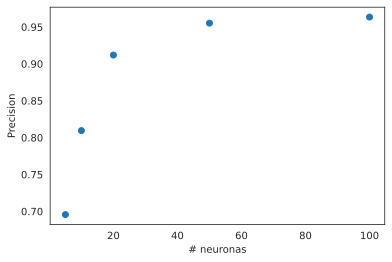

In [ ]:
#aqui se analiza el tercer caso en donde se varía el número de neuronas para tres capas escondidas
n_list = [5,10,20,50,100] #numero de neuronas a incluir en cada capa
precision_c = []  #lista que a va a guardar la precision para cada modelo con tres capas escondidas

for i in n_list:
  model = MLPClassifier(hidden_layer_sizes = (i,i,i), activation = 'relu', solver = 'lbfgs')
  model.fit(X_train1,y_train1)
  y_predict1 = model.predict(X_validation)
  precision_c.append(round(accuracy_score(y_validation, y_predict1),5))
#grafica de precision vs numero de neuronas para un modelo con tres capas escondidas
plt.scatter(n_list, precision_c)
plt.xlabel('# neuronas')
plt.ylabel('Precision')

### Gráficas Evaluativas

Caso A


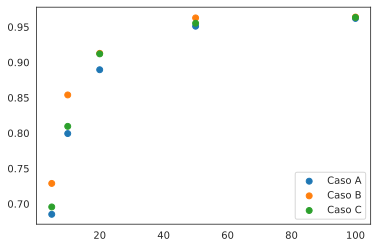

In [ ]:
list = [['Caso A', 'Caso B', 'Caso C'], precision_a, precision_b, precision_c]
print(list[0][0])
#grafica de precision vs numero de neuronas para los tres casos analizados 
for i in range(1,len(list)):
  plt.scatter(n_list,list[i], label = list[0][i-1])
plt.legend()
plt.show()

# **Conclusiones gráficas evaluativas**

A partir de la gráfica realizada anteriormente se puede evidenciar que para el caso en donde se hacía uso del menor número de neuronas que corresponde a 5, funciona mejor la red que contiene una única capa escondida. Después para los números de neuronas entre 5 y 100, siempre tuvo una mayor precisión el modelo de una red con dos capas escondidas. Unicamente el modelo con tres capas escondidas tuvo una mayor precisión cuando cada capa contaba con 100 neuronas.

Adicionalmente, se puede observar que la precisión tiene una tendencia de tipo logaritmica; es decir, que un mayor número de capas o neuronas puede tener un cambio muy pequeño sobre la precisión que puede estar no muy bien justificado de acuerdo a los requerimientos para ejecutar ese tipo de modelo. 

Se observa que previamente nosotros hicimos uso del modelo cuya precisión es alta, donde también se encuentra una buena diferencia entre los resultados de usar una o tres capas y además es un punto que corresponde a una especie de codo de la gráfica de precisión versus número de neuronas. 

Precisión 0.9683
      0     1
0  7145   269
1   201  7213
[[7145  269]
 [ 201 7213]]


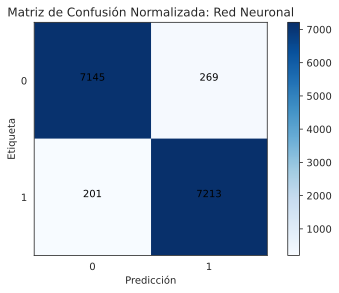

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes = (100,100), activation = 'relu', solver = 'lbfgs') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train,y_train) # Ajuste el modelo con los datos del conjunto A #
y_predict = model.predict(X_test) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

Precisión 0.96878
      0     1
0  7126   288
1   175  7239
[[7126  288]
 [ 175 7239]]


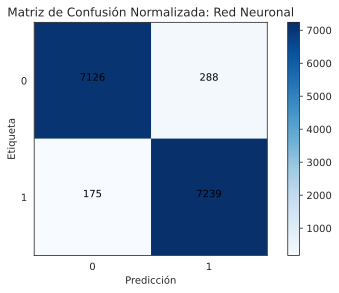

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes = (100,100,100), activation = 'relu', solver = 'lbfgs') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit(X_train,y_train) # Ajuste el modelo con los datos del conjunto A #
y_predict = model.predict(X_test) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #

print(f'Precisión {round(accuracy_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

# **Conclusiones mejores modelos**
Aquí se observa el comportamiento esperado, para las tres capas de 100 neuronas hay una mayor precisión que para el modelo con dos capas de 100 neuronas. A su vez, estos dos modelos tienen una mejor precisión sobre el modelo con 2 capas cada una con 20 neuronas. Los valores de precisión que toman estos tres son de $0.969$, $0.967$ y $0.931$ respectivamente, los cuales difieren entre sí a un orden de magnitud $10^{-2}$; mientras que, para los dos modelos con mayor precisión difieren con un orden de magnitud de $10^{-3}$, lo cual puede no ser muy significativo.

# Bono (2 puntos)

Implemente el mejor modelo de red neuronal. Desarrolle el método de **_backpropagation_** para realizar el entrenamiento de la red sin utilizar ningún tipo de librería que tenga funciones prestablecidas con objetivos de apoyo en el tema de Machine Learning. Puede utilizar Numpy, Pandas, etc. NO puede utilizar: SciKit-Learn, Tensorflow/Keras, PyTorch, etc.

El bono debe estar COMPLETO y se debe observar una curva de aprendizaje a través de las iteraciones que permita obtener resultados aceptables con respecto a la red definida a partir de SciKit-Learn. De lo contrario, no se tomará como válido.

In [ ]:
X_train['Bias'] = 1.0
X_train.head()

,Gender,Reality,ChldNo_1,ChldNo_2More,gp_inc_medium,gp_inc_high,wkphone,gp_Age_high,gp_Age_highest,gp_Age_low,gp_Age_lowest,gp_worktm_high,gp_worktm_highest,gp_worktm_low,gp_worktm_medium,occyp_hightecwk,occyp_officewk,famsizegp_1,famsizegp_3more,houtp_Co-op apartment,houtp_Municipal apartment,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,famtp_Civil marriage,famtp_Separated,famtp_Single / not married,famtp_Widow,Bias
32515,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14471,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
16400,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29956,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39904,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#funcion que calcula el error
def error(y,x):
  return 0.5*(y-x)**2

#funcion que calcula el gradiente del error
def error_gradient():
  return(x-y)

#funcion relu para cada capa oculta
def relu(x):
  if x<=0:
    return 0
  else:
    return x

#gradiente de la funcion relu para cada capa oculta
def relu_gradient(x):
  if x<=0:
    return 0
  return 1

#creacion de una matriz de pesos para cada neurona 
def matrix_w0(neurons, dimension):
  a = np.random.rand(neurons, dimension)
  return a 

#funcion que retorna la salida de incluir los datos en la primera capa
def first_layer(neurons, X_train, matrix):
  z = np.ones((neurons,len(X_train)))
  for i in range(np.shape(X_train)[1]):
      z[:,i] = np.dot(matrix,np.array(X_train)[i])
  return z

#funcion que retorna la salida de las capas intermedias
def center_layer(neurons, z_in, matrix):
  z = np.ones((neurons, np.shape(z_in)[1]))
  z = np.dot(matrix.T,z_in)
  return z

#funcion que retorna la salida de ultima capa
def final_layer(neurons, z_in, matrix):
  z = np.ones((neurons,np.shape(z_in)[1]))
  z = np.dot(matrix.T,z_in)
  return z

#funcion del gradiente de los errores de la ultima capa
def g_error_final_layer(neurons,y_train, z_3):
  g_e = np.ones(neurons)
  for i in range(len(z_3)):
    g_e[i] = np.mean((y_train[i]-z_3[i])*np.vectorize(relu_gradient)(z_3[i])*z_3[i])
  return g_e

#funcion del gradiente de los errores de las capas distintas de la ultima
def g_error_layers(neurons, z, g_ll, y_train, z_3):
  g_e = np.ones(neurons)
  for i in range(len(z)):
    g_e[i] = np.mean(np.mean(y_train-z_3)*np.vectorize(relu_gradient)(z[i])*z[i])
  return g_e

#actualizacion de los pesos
def w_act(matrix, ge):
  for i in range(len(matrix)):
    matrix[i,:] = (matrix[i,:]+0.5*ge[i])/1000
  return matrix

def error(y_train, x):
  return 0.5*np.sum((y_train-x)**2)

In [ ]:
#calculo de las salidas para cada neurona en cada capa

#salida primera capa
neurons = 20
dimension = np.shape(X_train)[1]

#matriz de pesos para la primera capa
matrix_0 = matrix_w0(neurons, dimension)

#matriz de pesos para la segunda capa
matrix_1 = matrix_w0(neurons, neurons)

#matriz de pesos para la tercera capa 
matrix_2 = matrix_w0(neurons, neurons)

#matriz de pesos para la ultima capa
matrix_3 = matrix_w0(neurons, 1)

total_error = float('inf')

list_of_errors = []

for i in range(5):

#salida de la primer capa
  z_0 = first_layer(neurons, X_train, matrix_0)

#se aplica la funcion relu a la primera salida
  z_0 = np.vectorize(relu)(z_0)

#salida segunda capa
  z_1 = center_layer(neurons, z_0, matrix_1)

#se aplica la funcion relu a la salida de la segunda capa
  z_1 = np.vectorize(relu)(z_1)

#salida tercera capa
  z_2 = center_layer(neurons, z_1, matrix_2)

#se aplica la funcion relu a la salida de la tercera capa
  z_2 = np.vectorize(relu)(z_2)

#salida de la ultima capa
  z_3 = final_layer(neurons, z_2, matrix_3)

#se aplica la funcion relu a la primera salida
  z_3 = np.vectorize(relu)(z_3)

#gradiente de los errores de la ultima capa
  g_efl = g_error_final_layer(neurons, y_train, z_3)

#gradiente de los errores de la tercera capa
  g_e3l = g_error_layers(neurons, z_2, g_efl, y_train, z_3)

#gradiente de los errores de la segunda capa
  g_e2l = g_error_layers(neurons, z_1, g_e3l, y_train, z_3)

#gradiente de los errores de la primera capa
  g_e1l = g_error_layers(neurons, z_0, g_e2l, y_train, z_3)

#calculo del error las capas
#error en la ultima capa
  error1 = error(y_train, z_3)

#error en la tercera capa
  error2 = error(y_train, z_2)

#error en la segunda capa
  error3 = error(y_train, z_1)

#error en la primera capa
  error4 = error(y_train, z_0)

  total_error = error1+error2+error3+error4
  list_of_errors.append(total_error)

#actualizacion de los pesos
  matrix_0 = w_act(matrix_0, g_e1l)
  matrix_1 = w_act(matrix_1, g_e2l)
  matrix_2 = w_act(matrix_2, g_e3l)
  matrix_3 = w_act(matrix_3, g_efl)

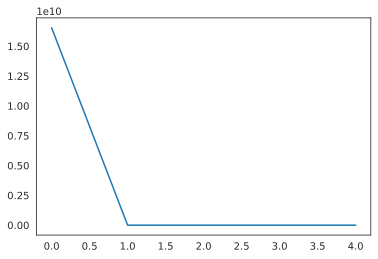

In [ ]:
plt.plot(list_of_errors)